In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import cartopy.crs as ccrs
import cartopy

In [4]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [5]:
import dask

In [6]:
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

# Global loading

In [7]:
years_1 = ('2020', '2030')
years_2 = ('2040', '2050')
years_3 = ('2070', '2080')


time_1 = slice(*years_1)
time_2 = slice(*years_2)
time_3 = slice(*years_3)

In [8]:
titles = [
    "Internal variability",
    "Model uncertainty",
    "Scenario uncertainty",
    None,None,None,
    None,None,None,
]
y_labels = [
    f'1st decade\n({list(years_1)[0]}-{list(years_1)[1]})',
    None,None,
    f'3rd decade\n({list(years_2)[0]}-{list(years_2)[1]})',
    None,None,
    f'6th decade\n({list(years_3)[0]}-{list(years_3)[1]})',
    None,None,
]

## Max temperature

In [9]:
models = ['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3']

In [10]:
mmle_scenarios_x=[]
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for scenario in  scenarios:
    mmle_loaded_tasmax = MultiModelLargeEnsemble('cmip6', 'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=scenario,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle_loaded_tasmax.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{scenario}_tasmax_default_quantile_return_10yr')
    mmle_scenarios_x.append(mmle_loaded_tasmax.x)
mmle_loaded_tasmax.x = xr.concat(mmle_scenarios_x, scenarios).rename({'concat_dim':'scenario'})

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/tasmax.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp126/day/tasmax.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr/KACE-1-0-G.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr/INM-CM4-8.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr/IPSL-CM6A-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmi

In [11]:
mmle_tasmax = MultiModelLargeEnsemble(models, 'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
mmle_tasmax.compute_x(x_type='quantile_return', load=True, name=f'tasmax_default_quantile_return_10yr')
mmle_tasmax.compute_LE()

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/EC-Earth3.zarr


/opt/conda/envs/carla/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [12]:
mmle_tasmax.results['S_FIT'] = mmle_loaded_tasmax.x.mean('model').var('scenario').isel(member_id=0)
mmle_tasmax.results['T_LE'] = mmle_tasmax.results['S_FIT'] + mmle_tasmax.results['M_LE'] + mmle_tasmax.results['Ibar_LE']
mmle_tasmax.results['T_LE_no_S'] = mmle_tasmax.results['M_LE'] + mmle_tasmax.results['Ibar_LE']

mmle_tasmax.results['T_LE_ideal'] = mmle_tasmax.results['S_FIT'] + mmle_tasmax.results['Ibar_LE']

mmle_tasmax.results['frac_M_LE'] = mmle_tasmax.results['M_LE'] / (mmle_tasmax.results['T_LE'])
mmle_tasmax.results['frac_Ibar_LE'] = mmle_tasmax.results['Ibar_LE'] / (mmle_tasmax.results['T_LE'])
mmle_tasmax.results['frac_S_LE'] = mmle_tasmax.results['S_FIT'] / (mmle_tasmax.results['T_LE'])

In [13]:
mmle_tasmax.x.load()
mmle_tasmax.results.load()

/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:       (time: 181, lat: 71, lon: 144, model: 5)
Coordinates:
  * time          (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat           (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * model         (model) <U13 'MIROC6' 'cesm_lens' ... 'EC-Earth3'
    q_values      (model, lat, lon) float64 268.3 268.2 268.1 ... 275.5 275.5
    quantile      (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    member_id     <U8 'r1i1p1f1'
Data variables:
    M_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    I_LE          (model, time, lat, lon) float64 nan nan nan ... nan nan nan
    Ibar_LE       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    S_FIT         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE_no_S     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE_ideal    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_M_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_Ibar_LE  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_S_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [14]:
results_tasmax  = convert_longitude_360to180(mmle_tasmax.results)

In [15]:
data = [
results_tasmax['frac_Ibar_LE'].sel(time=time_1).mean('time'),
results_tasmax['frac_M_LE'].sel(time=time_1).mean('time'),
results_tasmax['frac_S_LE'].sel(time=time_1).mean('time'),

results_tasmax['frac_Ibar_LE'].sel(time=time_2).mean('time'),
results_tasmax['frac_M_LE'].sel(time=time_2).mean('time'),
results_tasmax['frac_S_LE'].sel(time=time_2).mean('time'),

results_tasmax['frac_Ibar_LE'].sel(time=time_3).mean('time'),
results_tasmax['frac_M_LE'].sel(time=time_3).mean('time'),
results_tasmax['frac_S_LE'].sel(time=time_3).mean('time'),

]

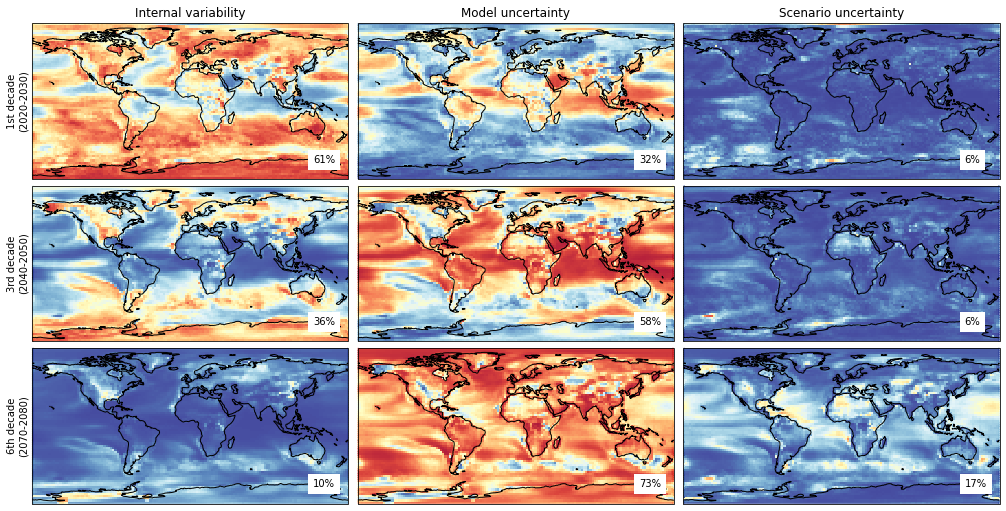

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,7), subplot_kw=dict(projection=ccrs.PlateCarree()))
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib.

for ax, data_i, title, y_label in zip(axes.ravel(), data, titles, y_labels):
    percentage = int(np.round((data_i.mean(('lat', 'lon'))*100).values))
    # ax.coastlines(linewidth=2, color='gray')
    data_i.plot(ax=ax, cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=False,
    # add_colorbar=True, cbar_kwargs={'orientation': 'horizontal', 'shrink': 0.7, 'pad': 0.01},
    alpha=0.9   # This makes it a little less jarring
    )
    ax.set_title(title)
    ax.text(140, -70, f'{percentage}%',
        bbox={'facecolor': 'white', 
            'alpha': 1, 'pad': 5, 
            'edgecolor' : 'none'})
    if y_label:
        ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)
    ax.coastlines(linewidth=1, color='k')
# plt.subplots_adjust(left=0.05, bottom=0.02, wspace=0, hspace=0.03)
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.

In [17]:
variable = 'tasmax'
fig.savefig(f'./plots/{variable}_LE_global_fractions.png', dpi=200)

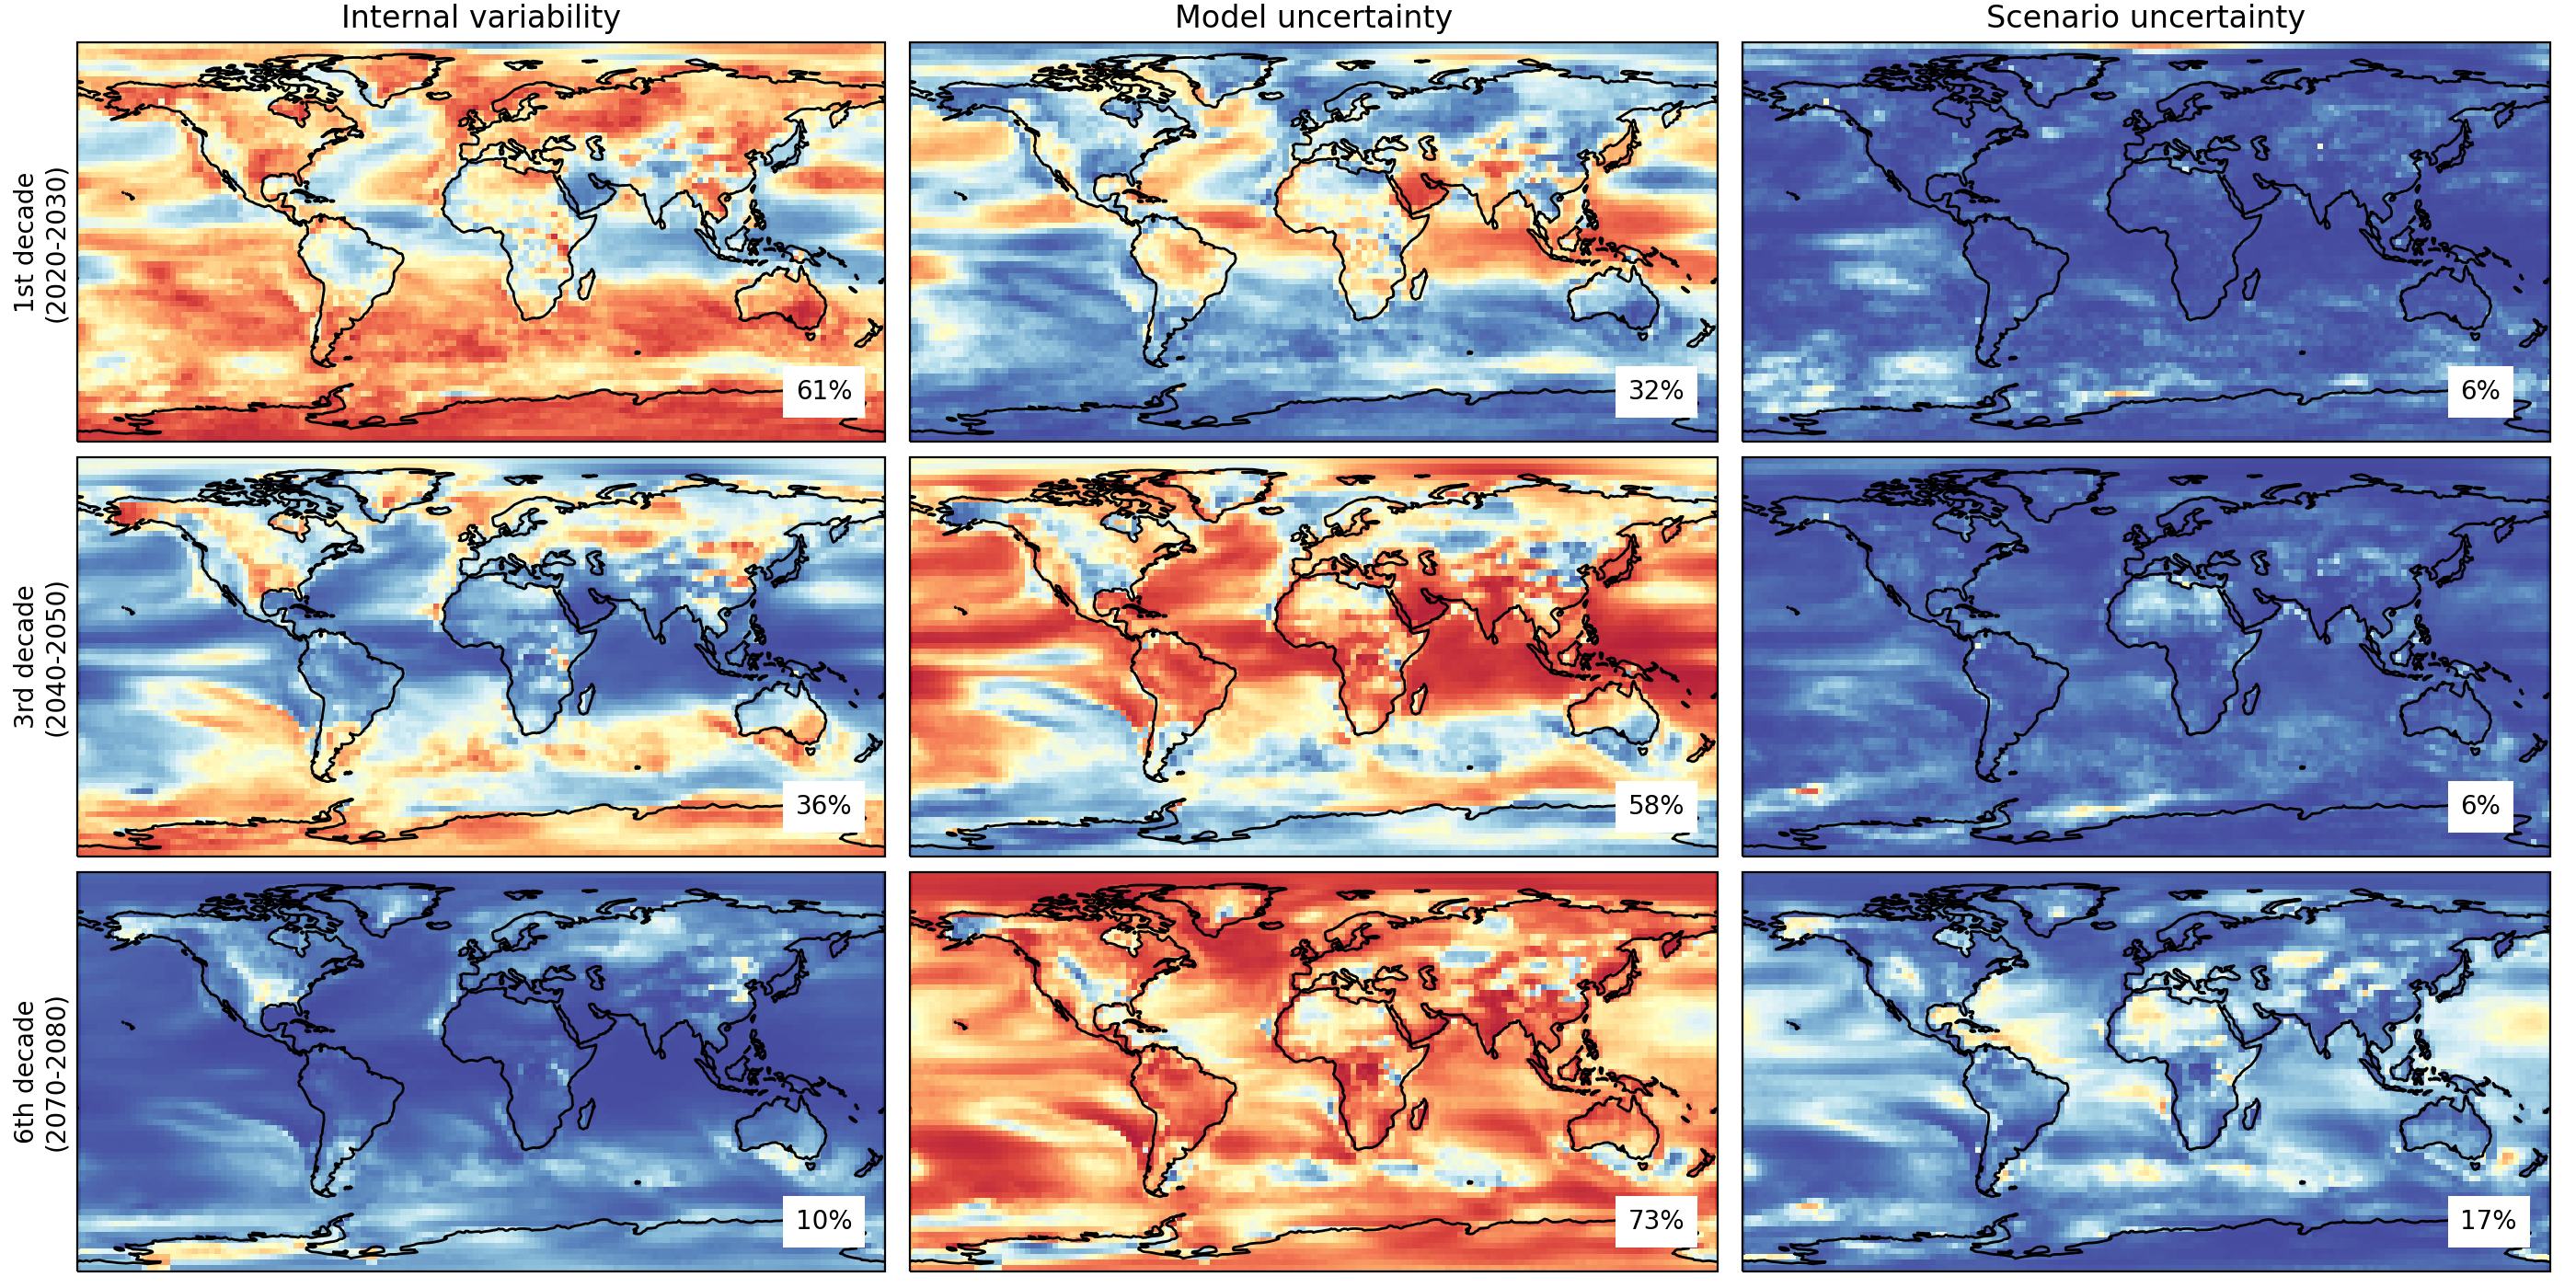

In [18]:
from IPython.display import Image
Image(filename=f'./plots/{variable}_LE_global_fractions.png')   # Don't believe what Jupyter shows you!

## Precipitation

In [19]:
mmle_scenarios_x=[]
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for scenario in  scenarios:
    mmle_loaded_pr = MultiModelLargeEnsemble('cmip6', 'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=scenario,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle_loaded_pr.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{scenario}_pr_default_quantile_return_10yr')
    mmle_scenarios_x.append(mmle_loaded_pr.x)
mmle_loaded_pr.x = xr.concat(mmle_scenarios_x, scenarios).rename({'concat_dim':'scenario'})

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/pr.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp126/day/pr.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/MPI-ESM1-2-HR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/IPSL-CM6A-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/EC-Earth3-Veg-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_

In [20]:
mmle_pr = MultiModelLargeEnsemble(models, 'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
mmle_pr.compute_x(x_type='quantile_return', load=True, name=f'pr_default_quantile_return_10yr')
mmle_pr.compute_LE()

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/EC-Earth3.zarr


/opt/conda/envs/carla/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [21]:
mmle_pr.results['S_FIT'] = mmle_loaded_pr.x.mean('model').var('scenario').isel(member_id=0)
mmle_pr.results['T_LE'] = mmle_pr.results['S_FIT'] + mmle_pr.results['M_LE'] + mmle_pr.results['Ibar_LE']
mmle_pr.results['T_LE_no_S'] = mmle_pr.results['M_LE'] + mmle_pr.results['Ibar_LE']

mmle_pr.results['T_LE_ideal'] = mmle_pr.results['S_FIT'] + mmle_pr.results['Ibar_LE']



mmle_pr.results['frac_M_LE'] = mmle_pr.results['M_LE'] / (mmle_pr.results['T_LE'])
mmle_pr.results['frac_Ibar_LE'] = mmle_pr.results['Ibar_LE'] / (mmle_pr.results['T_LE'])
mmle_pr.results['frac_S_LE'] = mmle_pr.results['S_FIT'] / (mmle_pr.results['T_LE'])

In [22]:
mmle_pr.x.load()
mmle_pr.results.load()

MemoryError: Unable to allocate 4.89 GiB for an array with shape (5, 71, 181, 71, 144) and data type float64

In [ ]:
results_pr  = convert_longitude_360to180(mmle_pr.results)

In [ ]:
data = [
results_pr['frac_Ibar_LE'].sel(time=time_1).mean('time'),
results_pr['frac_M_LE'].sel(time=time_1).mean('time'),
results_pr['frac_S_LE'].sel(time=time_1).mean('time'),

results_pr['frac_Ibar_LE'].sel(time=time_2).mean('time'),
results_pr['frac_M_LE'].sel(time=time_2).mean('time'),
results_pr['frac_S_LE'].sel(time=time_2).mean('time'),

results_pr['frac_Ibar_LE'].sel(time=time_3).mean('time'),
results_pr['frac_M_LE'].sel(time=time_3).mean('time'),
results_pr['frac_S_LE'].sel(time=time_3).mean('time'),

]

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,7), subplot_kw=dict(projection=ccrs.PlateCarree()))
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib.

for ax, data_i, title, y_label in zip(axes.ravel(), data, titles, y_labels):
    percentage = int(np.round((data_i.mean(('lat', 'lon'))*100).values))
    # ax.coastlines(linewidth=2, color='gray')
    data_i.plot(ax=ax, cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=False,
    # add_colorbar=True, cbar_kwargs={'orientation': 'horizontal', 'shrink': 0.7, 'pad': 0.01},
    alpha=0.9   # This makes it a little less jarring
    )
    ax.set_title(title)
    ax.text(140, -70, f'{percentage}%',
        bbox={'facecolor': 'white', 
            'alpha': 1, 'pad': 5, 
            'edgecolor' : 'none'})
    if y_label:
        ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)
    ax.coastlines(linewidth=1, color='k')
# plt.subplots_adjust(left=0.05, bottom=0.02, wspace=0, hspace=0.03)
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.

In [ ]:
variable = 'pr'
fig.savefig(f'./plots/{variable}_LE_global_fractions.png', dpi=200)

In [ ]:
from IPython.display import Image
Image(filename=f'./plots/{variable}_LE_global_fractions.png')   # Don't believe what Jupyter shows you!

## Contributions

In [ ]:
data =[
results_tasmax,
results_pr
]

In [ ]:
titles = [
    'Daily Maximum Temperature',
    'Daily Precipitation'
]
y_labels = [
    'Percent Contribution to Total Uncertainty',
    None
]

In [ ]:
14*(2/3)

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, constrained_layout=True,figsize=(9.5,7/2))

for ax, results, title, y_label in zip(axes.ravel(), data, titles, y_labels):

    time=results.sel(time=slice('2020', None)).time.values
    y1=results['frac_M_LE'].mean(('lat', 'lon')).sel(time=slice('2020', None))*100
    y2=y1 + results['frac_S_LE'].mean(('lat', 'lon')).sel(time=slice('2020', None))*100
    
    ax.fill_between(time,y2,100,label='Internal',color='#ff7f0e')
    ax.fill_between(time,y1,y2,label='Scenario',color='#2ca02c')
    ax.fill_between(time,0,y1,label='Model',color='#1f77b4')
    ax.plot(time,y1,color='k',linewidth=1)
    ax.plot(time,y2,color='k',linewidth=1)

    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    ax.set_ylim(bottom=0,top=100)
    ax.set_title(title)
    ax.set_xlabel('')

    if y_label:
        ax.set_ylabel(y_label)
axes[0].legend(loc=4)

plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.


In [ ]:
fig.savefig('./plots/percent_contribution.png', dpi=200)

## Signal to noise ratio

In [ ]:
ref_tasmax = mmle_tasmax.x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model', 'lan', 'lon'))
signal_tasmax = mmle_tasmax.x.mean(('member_id', 'model')) - ref_tasmax

In [ ]:
SNR_tasmax = np.abs(signal_tasmax/ np.sqrt(mmle_tasmax.results['T_LE']))
SNR_ideal_tasmax = np.abs(signal_tasmax/ np.sqrt(mmle_tasmax.results['T_LE_ideal']))

SNR1 = np.abs(signal_tasmax/ np.sqrt(mmle_tasmax.results['T_LE_no_S']))
SNR_ideal1 = np.abs(signal_tasmax/ np.sqrt(mmle_tasmax.results['Ibar_LE']))

In [ ]:
data =[
mmle_tasmax,
mmle_pr
]

titles = [
    'Daily Maximum Temperature',
    'Daily Precipitation'
]
y_labels = [
    'Signal to Noise Ratio',
    None
]

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, constrained_layout=True,figsize=(9.5,7/2))

for ax, mmmle_data, title, y_label in zip(axes.ravel(), data, titles, y_labels):

    ref = mmmle_data.x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model', 'lat', 'lon'))
    signal = mmmle_data.x.mean(('member_id', 'model')) - ref

    SNR = np.abs(signal/ np.sqrt(mmmle_data.results['T_LE']))
    SNR_ideal = np.abs(signal/ np.sqrt(mmmle_data.results['T_LE_ideal']))

    SNR1 = np.abs(signal/ np.sqrt(mmmle_data.results['T_LE_no_S']))
    SNR_ideal1 = np.abs(signal/ np.sqrt(mmmle_data.results['Ibar_LE']))

    SNR.plot(ax=ax, lw=2, label='SNR with S',color='k')
    SNR_ideal.plot(ax=ax, lw=2, label='SNR Ideal with S',linestyle='dashed',color='k')
    SNR1.plot(ax=ax, lw=2, label='SNR without S',color='r')
    SNR_ideal1.plot(ax=ax, lw=2, label='SNR Ideal without S',color='r',linestyle='dashed')

    ax.axhline(1,color='gray',linewidth=2, label='SNR = 1')
    
        # x.sel(variable=v, region=r, model=m).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    # ax.set_ylim(bottom=0)
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.03)) 
    ax.spines["left"].set_position(("axes", -0.02))


plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get gray

In [ ]:
# region1 = Seattle, region2 = Sydney Australia, region3 = Lagos Nigeria 
regions = ['Seattle', 'Sydney', 'Lagos']
lats = [47.6, -33.8, 6.5]
lons = [237.7, 151.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})